<a href="https://colab.research.google.com/github/huynhminh1007/ML_2024/blob/main/Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

%matplotlib inline

# Dataset Overview

**Read Dataset**

In [ ]:
# Link dataset
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/datasets'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/datasets


In [ ]:
# Đọc dataset
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Dataset Overview**

In [ ]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
# Thống kê
df.describe().T

# Phân tích đơn biến

**Vẽ histogram cho feature liên tục**

In [ ]:
# Các feature giá trị liên tục
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

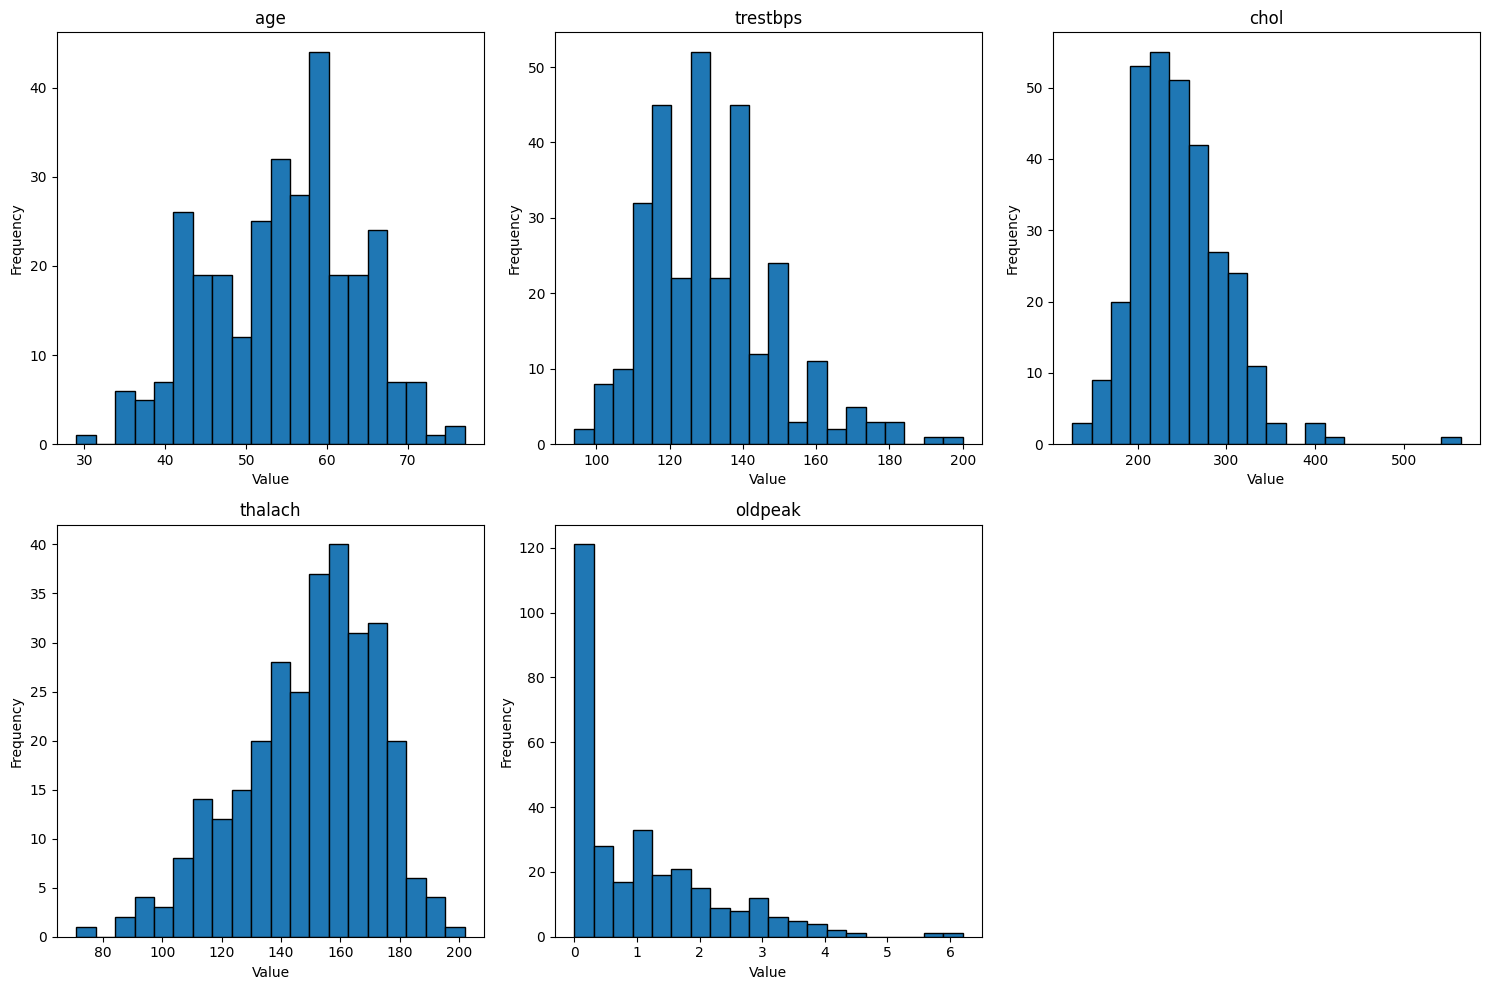

In [ ]:
df_continuous = df[continuous_features]
# Vẽ histogram cho tất cả các biến số trong df_continuous
n = len(df_continuous.columns)
# Cấu hình 3 biểu đồ trên 1 hàng
fig, axes = plt.subplots(nrows=(n + 2) // 3, ncols=3, figsize=(15, 5 * ((n + 2) // 3)))
axes = axes.flatten()

for i, column in enumerate(df_continuous.columns):
    axes[i].hist(df_continuous[column], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Ẩn các subplot không sử dụng
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Vẽ biểu đồ thanh cho feature rời rạc**

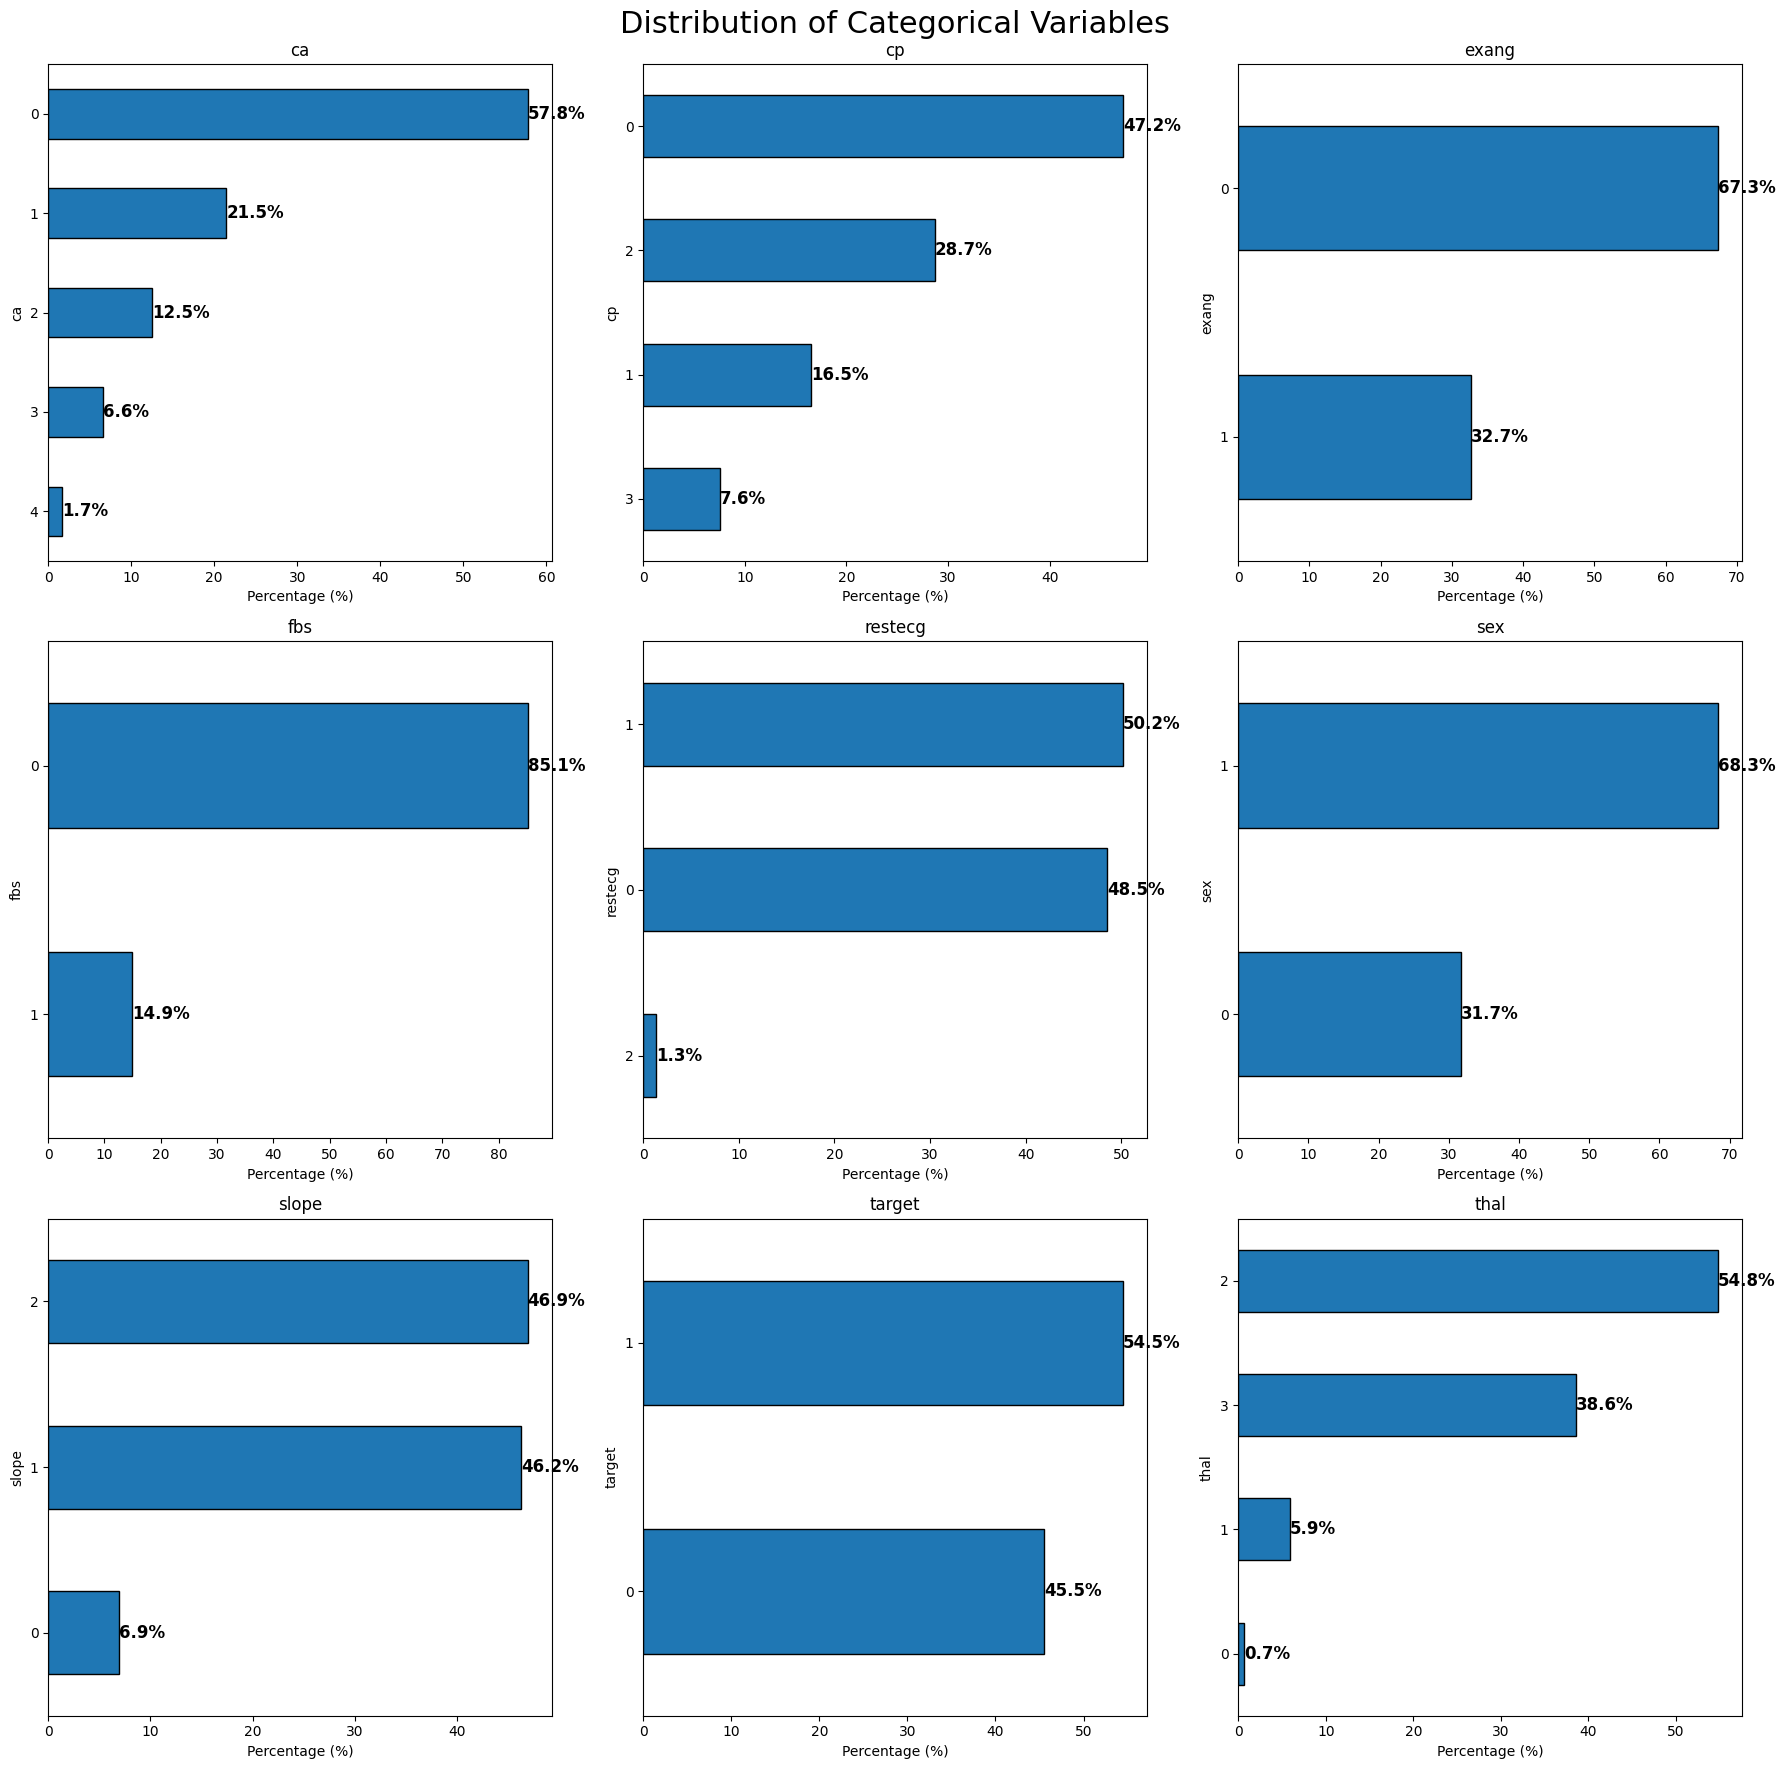

In [ ]:
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

# Tạo subplots
num_cols = 3
num_rows = (len(categorical_features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, num_rows * 6))

# Vẽ biểu đồ thanh nằm ngang cho các biến phân loại
for ax, col in zip(axes.flatten(), categorical_features):
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    value_counts.plot(kind='barh', ax=ax, edgecolor='black')
    ax.set_xlabel('Percentage (%)')
    ax.set_title(col)

    # Thêm tỷ lệ phần trăm vào các thanh
    for index, value in enumerate(value_counts):
        ax.text(value, index, f'{value:.1f}%', fontsize=12, weight='bold', va='center')

# Tắt các axes không dùng đến
for ax in axes.flatten()[len(categorical_features):]:
    ax.axis('off')

plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Phân tích đa biến

**Feature liên tục**

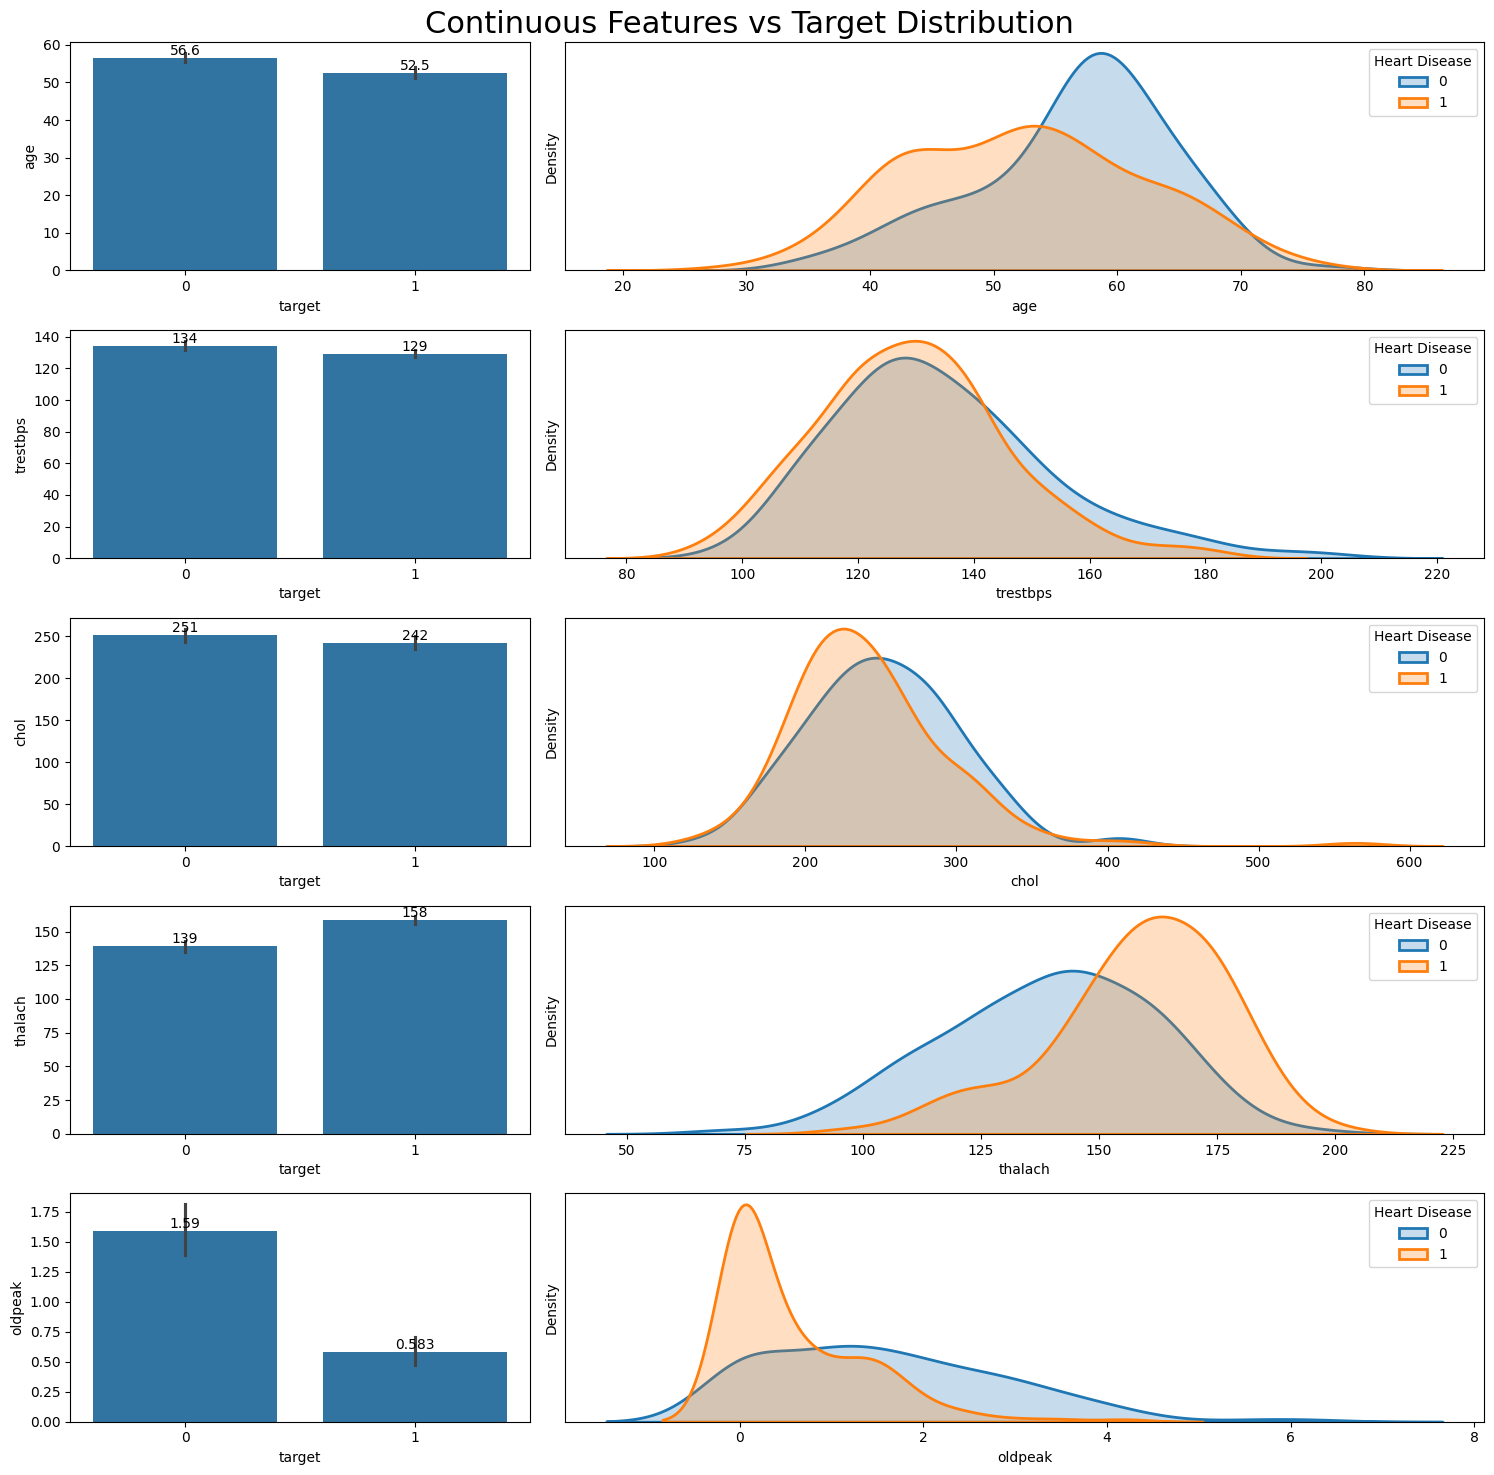

In [ ]:
# Tạo các subplot
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Lặp qua từng đặc trưng liên tục để tạo biểu đồ thanh và biểu đồ KDE
for i, col in enumerate(continuous_features):
    # Biểu đồ thanh hiển thị giá trị trung bình của đặc trưng cho mỗi loại mục tiêu
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])

    # Biểu đồ KDE hiển thị phân phối của đặc trưng cho mỗi loại mục tiêu
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')

    # Thêm giá trị trung bình vào biểu đồ thanh
    for cont in graph.containers:
        graph.bar_label(cont, fmt='%.3g')

# Đặt tiêu đề cho toàn bộ hình
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()

**Feature rời rạc**

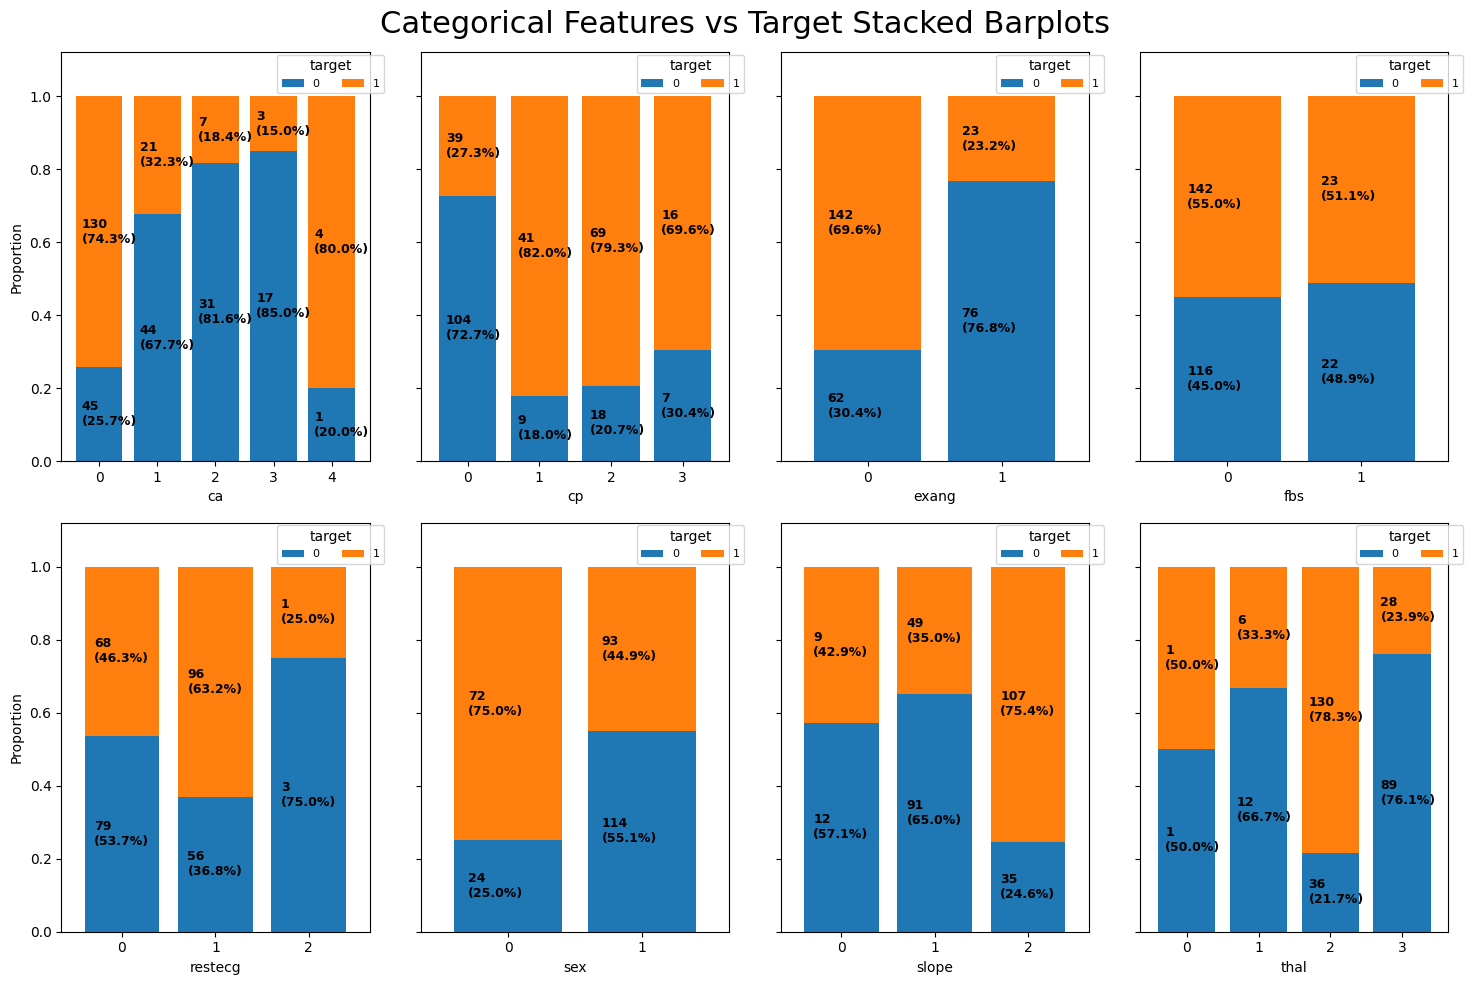

In [ ]:
# Loại bỏ 'target' khỏi danh sách các đặc trưng phân loại
categorical_features = [feature for feature in categorical_features if feature != 'target']

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):

    # Tạo bảng chéo hiển thị tỷ lệ của các khoản vay đã mua và chưa mua cho mỗi loại của đặc trưng
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])

    # Sử dụng tham số normalize=True để có tỷ lệ dữ liệu theo từng chỉ mục
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Vẽ biểu đồ thanh chồng lên nhau
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8,
                        legend=False, ylabel='Proportion', sharey=True)

    # Thêm tỷ lệ và số lượng của các thanh cá nhân vào biểu đồ
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'{count}\n({np.round(proportion * 100, 1)}%)',
                         color = "black", fontsize=9, fontweight="bold")

    # Thêm chú thích
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Đặt giới hạn trục y
    ax[x,y].set_ylim([0,1.12])
    # Xoay nhãn trục x
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)


plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()
plt.show()

# Tiền xử lý dữ liệu

**Missing Value**

In [ ]:
df.isnull().sum().sum()

0

**Chuẩn hóa giá trị categorical**

In [ ]:
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Chuyển các cột one-hot encoding từ boolean thành integer
one_hot_columns = [col for col in df_encoded.columns if any(prefix in col for prefix in ['cp_', 'restecg_', 'thal_'])]
df_encoded[one_hot_columns] = df_encoded[one_hot_columns].astype(int)

# Chuyển các biến phân loại còn lại thành integer
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0


**Chia tập dữ liệu**

In [ ]:
# Tạo X và y từ dataset
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# Chia data thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# In kích thước của các tập huấn luyện và kiểm tra
print(f'Kích thước của X_train: {X_train.shape}')
print(f'Kích thước của y_train: {y_train.shape}')
print(f'Kích thước của X_test: {X_test.shape}')
print(f'Kích thước của y_test: {y_test.shape}')

Kích thước của X_train: (242, 18)
Kích thước của y_train: (242,)
Kích thước của X_test: (61, 18)
Kích thước của y_test: (61,)


# Random Forest

**Tạo Param Grid**

In [ ]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

**Tạo model**

In [ ]:
rf = RandomForestClassifier(random_state=0)

**Các function bổ sung**

In [ ]:
# Fine-tune model
def find_best_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    clf_grid.fit(X_train, y_train)
    best_hyperparameters = clf_grid.best_params_

    return clf_grid.best_estimator_, best_hyperparameters

In [ ]:
# print Pretty Table
def get_score(model, X_test, y_test):
  y_pred = model.predict(X_test)

  accuracy = round(metrics.accuracy_score(y_test, y_pred), 4)
  precision = round(metrics.precision_score(y_test, y_pred, average='macro'), 4)
  recall = round(metrics.recall_score(y_test, y_pred, average='macro'), 4)
  f1 = round(metrics.f1_score(y_test, y_pred, average='macro'), 4)

  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

def get_table(models,  X_test, y_test):
  results = {}
  for name, model in models.items():
    score = get_score(model, X_test, y_test)
    results[name] = {'Accuracy': score['accuracy'], 'Precision': score['precision'], 'Recall': score['recall'], 'F1': score['f1']}

  table = PrettyTable()
  table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1"]
  for name, scores in results.items():
    table.add_row([name, scores['Accuracy'], scores['Precision'], scores['Recall'], scores['F1']])

  return table

**Fine-tune Model**

In [ ]:
# Sử dụng  find_best_hyperparameters để tìm model với hyperparameters tốt nhất
rf_clf, best_rf_hyperparams = find_best_hyperparameters(rf, param_grid_rf, X_train, y_train)
print('Random Forest Optimal Hyperparameters: \n', best_rf_hyperparams)

Random Forest Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


**Đánh giá Model**

In [ ]:
models = {
    'Random Forest': rf_clf
}

print(get_table(models, X_test, y_test))

+---------------+----------+-----------+--------+--------+
|     Model     | Accuracy | Precision | Recall |   F1   |
+---------------+----------+-----------+--------+--------+
| Random Forest |  0.8361  |   0.8374  | 0.8323 | 0.8339 |
+---------------+----------+-----------+--------+--------+


# Neural Network

**Tạo Param Grid**

In [ ]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100, 150)],
    'max_iter': [100, 200, 300],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate': ['constant','adaptive']
}

**Tạo Model**

In [ ]:
mlp = MLPClassifier()

**Fine-tune Model**

In [ ]:
mlp_clf, best_mlp_hyperparams = find_best_hyperparameters(mlp, param_grid_mlp, X_train, y_train)
print('Multilayer Perceptron Classifier Optimal Hyperparameters: \n', best_mlp_hyperparams)

Multilayer Perceptron Classifier Optimal Hyperparameters: 
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}


**Đánh giá Model**

In [ ]:
models = {
    'Multilayer Perceptron Classifier': mlp_clf
}

print(get_table(models, X_test, y_test))

+----------------------------------+----------+-----------+--------+--------+
|              Model               | Accuracy | Precision | Recall |   F1   |
+----------------------------------+----------+-----------+--------+--------+
| Multilayer Perceptron Classifier |  0.8852  |   0.8842  | 0.8858 | 0.8848 |
+----------------------------------+----------+-----------+--------+--------+


# Kết luận

In [ ]:
models = {
    'Random Forest': rf_clf,
    'Multilayer Perceptron Classifier': mlp_clf
}

print(get_table(models, X_test, y_test))

+----------------------------------+----------+-----------+--------+--------+
|              Model               | Accuracy | Precision | Recall |   F1   |
+----------------------------------+----------+-----------+--------+--------+
|          Random Forest           |  0.8361  |   0.8374  | 0.8323 | 0.8339 |
| Multilayer Perceptron Classifier |  0.8852  |   0.8842  | 0.8858 | 0.8848 |
+----------------------------------+----------+-----------+--------+--------+
